In [1]:
# The ultimate target feature: delay per stop

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 

# Read csv file into a dataframe.
df = pd.read_csv('csv_data/route4.csv')

/Users/reggiemurphy/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df.shape

(689030, 16)

# 1.0 Data Cleaning 

## 1.1 Rename confusing column names

In [3]:
df = df.rename(columns={'Timeframe': 'Start_date'})

## 1.2 Dropping duplicates

In [4]:
df=df.drop_duplicates(keep='first')

In [5]:
df.shape

(681530, 16)

## 1.3 Dropping constant columns

In [6]:
for column in df.columns:
    print(column + "," + str(len(df[column].unique())))

Unnamed: 0,563375
Timestamp,387316
LineID,1
Direction,1
Journey_Pattern_ID,7
Start_date,32
Vehicle_Journey_ID,596
Operator,4
Congestion,2
Lon,34662
Lat,28283
Delay,3876
Block_ID,42
Vehicle_ID,116
Stop_ID,242
At_Stop,2


Direction is a constant - that is unexpected Line is constant as we filtered for line

In [7]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)

The direction is constant, the line ID is only constant due to a filter.

## 1.4 Check congestion

In [8]:
check_congestion=pd.crosstab(df.Congestion,df.Journey_Pattern_ID, margins=True)
check_congestion

Journey_Pattern_ID,00040001,00040002,00041001,00041002,033X1001,null,All
Congestion,,,,,,,
0,305071,2919,306941,2613,9,60618,678171
1,3033,0,311,0,0,0,3344
All,308104,2919,307252,2613,9,60618,681515


Congestion accounts for .5% of the dataset - given most peak buses are late this is not a main driving feature

In [9]:
df = df.drop('Congestion', axis=1)

## 1.5 Add new features

Change timestamp to DateTime

In [10]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

Binary feature - weekend

In [11]:
df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 5), 1, 0)

Hour of day

In [12]:
df['HourOfDay'] = df['Time'].dt.hour

Binary feature - evening time

In [13]:
df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

Binary feature - peak hours

In [14]:
df['IsPeakTime'] = np.where(((df['HourOfDay'] >= 7) & (df['HourOfDay'] <= 10)) | ((df['HourOfDay'] >= 16) & (df['HourOfDay'] <= 19)), 1, 0)

Binary feature - is school holiday

In [15]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

---

# 2.0 Merge Datasets

## 2.1 Merge bus stop info

In [16]:
df_bus_stop = pd.read_csv('csv_data/busstopinfo.csv', encoding='latin-1')

In [17]:
df_bus_stop_route4 = df_bus_stop.loc[(df_bus_stop.route1 == '4')]
df_bus_stop_route4.shape

(49, 43)

So there are 42 official Route 4 stops.

In [18]:
df_bus_stop_route4 = df_bus_stop_route4.rename(columns={'stopid': 'Stop_ID'})

In [19]:
df[(df.Vehicle_Journey_ID == 4915) & (df.Start_date == "2013-01-24")]

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday
536133,1359012643000000,4.0,null,2013-01-24,4915,HN,-6.278342,53.418129,36,4010,43042,324,0,2013-01-24 07:30:43,0,7,0,1,0
536145,1359012665000000,4.0,00040001,2013-01-24,4915,HN,-6.278342,53.418129,36,4010,43042,324,0,2013-01-24 07:31:05,0,7,0,1,0
536155,1359012684000000,4.0,00040001,2013-01-24,4915,HN,-6.271511,53.417774,36,4010,43042,324,0,2013-01-24 07:31:24,0,7,0,1,0
536176,1359012722000000,4.0,00040001,2013-01-24,4915,HN,-6.266300,53.417068,36,4010,43042,324,0,2013-01-24 07:32:02,0,7,0,1,0
536183,1359012745000000,4.0,00040001,2013-01-24,4915,HN,-6.278516,53.417789,140,4010,43042,324,0,2013-01-24 07:32:25,0,7,0,1,0
536196,1359012765000000,4.0,00040001,2013-01-24,4915,HN,-6.265911,53.416904,79,4010,43042,324,0,2013-01-24 07:32:45,0,7,0,1,0
536204,1359012782000000,4.0,00040001,2013-01-24,4915,HN,-6.265378,53.415203,79,4010,43042,7480,0,2013-01-24 07:33:02,0,7,0,1,0
536226,1359012823000000,4.0,00040001,2013-01-24,4915,HN,-6.265378,53.415203,79,4010,43042,7480,0,2013-01-24 07:33:43,0,7,0,1,0
536234,1359012844000000,4.0,00040001,2013-01-24,4915,HN,-6.265096,53.408710,46,4010,43042,7482,0,2013-01-24 07:34:04,0,7,0,1,0
536244,1359012863000000,4.0,00040001,2013-01-24,4915,HN,-6.265348,53.406845,46,4010,43042,7482,0,2013-01-24 07:34:23,0,7,0,1,0


Get southbound order of stops

In [20]:
df_southbound = df.loc[(df.Vehicle_ID == 43048) & (df.Vehicle_Journey_ID == 4909)]

In [21]:
# df[(df.Vehicle_ID == 43048)]["Vehicle_Journey_ID"].unique()

Get northbound order of stops

In [22]:
df_northbound = df.loc[(df.Vehicle_ID == 43048) & (df.Vehicle_Journey_ID == 4572)]

In [23]:
df_bus_stop_route4 = df_bus_stop_route4[['Stop_ID', 'fullname']]
df_bus_stop_route4.columns

Index(['Stop_ID', 'fullname'], dtype='object')

In [24]:
df_south = df_southbound.drop_duplicates(subset='Stop_ID', keep='first')

In [25]:
df_south['stop_order'] = df_south.groupby(['Vehicle_Journey_ID', 'At_Stop', 'Start_date', 'Vehicle_ID'])['Timestamp','Stop_ID'].cumcount().reindex()
df_south

/Users/reggiemurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,stop_order
53650,1357213531000000,4.0,null,2013-01-03,4909,HN,-6.274165,53.417923,0,4005,43048,324,0,2013-01-03 11:45:31,0,11,0,0,1,0
53676,1357213593000000,4.0,00040001,2013-01-03,4909,HN,-6.265767,53.416599,0,4005,43048,7480,0,2013-01-03 11:46:33,0,11,0,0,1,1
53703,1357213650000000,4.0,00040001,2013-01-03,4909,HN,-6.265000,53.409367,0,4005,43048,327,0,2013-01-03 11:47:30,0,11,0,0,1,2
53731,1357213711000000,4.0,00040001,2013-01-03,4909,HN,-6.264933,53.403683,0,4005,43048,7482,0,2013-01-03 11:48:31,0,11,0,0,1,3
53823,1357213923000000,4.0,00041001,2013-01-03,4909,HN,-6.263807,53.392265,-171,4005,43048,113,1,2013-01-03 11:52:03,0,11,0,0,1,0
53850,1357213983000000,4.0,00040001,2013-01-03,4909,HN,-6.264155,53.390282,-162,4005,43048,114,0,2013-01-03 11:53:03,0,11,0,0,1,4
53869,1357214024000000,4.0,00040001,2013-01-03,4909,HN,-6.265143,53.387920,-184,4005,43048,115,1,2013-01-03 11:53:44,0,11,0,0,1,1
53897,1357214083000000,4.0,00040001,2013-01-03,4909,HN,-6.265003,53.385361,-190,4005,43048,37,1,2013-01-03 11:54:43,0,11,0,0,1,2
53924,1357214143000000,4.0,00040001,2013-01-03,4909,HN,-6.265681,53.381332,-234,4005,43048,38,0,2013-01-03 11:55:43,0,11,0,0,1,5
53933,1357214164000000,4.0,00040001,2013-01-03,4909,HN,-6.265748,53.380424,-234,4005,43048,39,1,2013-01-03 11:56:04,0,11,0,0,1,3


In [26]:
df_north = df_northbound.drop_duplicates(subset='Stop_ID', keep='first')

In [27]:
df_north['stop_order'] = df_north.groupby(['Vehicle_Journey_ID', 'At_Stop', 'Start_date', 'Vehicle_ID'])['Timestamp','Stop_ID'].cumcount().reindex()
df_north

/Users/reggiemurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,stop_order
45296,1357197233000000,4.0,null,2013-01-03,4572,HN,-6.153733,53.288517,0,4004,43048,7330,1,2013-01-03 07:13:53,0,7,0,1,1,0
45357,1357197367000000,4.0,00041001,2013-01-03,4572,HN,-6.159831,53.286541,-25,4004,43048,2051,1,2013-01-03 07:16:07,0,7,0,1,1,1
45392,1357197447000000,4.0,00041001,2013-01-03,4572,HN,-6.165994,53.286362,-25,4004,43048,6086,1,2013-01-03 07:17:27,0,7,0,1,1,2
45416,1357197507000000,4.0,00041001,2013-01-03,4572,HN,-6.167912,53.287037,-25,4004,43048,3161,1,2013-01-03 07:18:27,0,7,0,1,1,3
45441,1357197568000000,4.0,00041001,2013-01-03,4572,HN,-6.167534,53.289749,-35,4004,43048,3162,1,2013-01-03 07:19:28,0,7,0,1,1,4
45458,1357197607000000,4.0,00041001,2013-01-03,4572,HN,-6.166771,53.292568,-114,4004,43048,3163,1,2013-01-03 07:20:07,0,7,0,1,1,5
45496,1357197687000000,4.0,00041001,2013-01-03,4572,HN,-6.169960,53.296001,-185,4004,43048,3164,0,2013-01-03 07:21:27,0,7,0,1,1,0
45543,1357197787000000,4.0,00041001,2013-01-03,4572,HN,-6.181291,53.301643,-426,4004,43048,3084,0,2013-01-03 07:23:07,0,7,0,1,1,1
45561,1357197828000000,4.0,00041001,2013-01-03,4572,HN,-6.183967,53.302956,-443,4004,43048,469,1,2013-01-03 07:23:48,0,7,0,1,1,6
45589,1357197888000000,4.0,00041001,2013-01-03,4572,HN,-6.190981,53.306885,-553,4004,43048,470,0,2013-01-03 07:24:48,0,7,0,1,1,2


In [28]:
df_order = df_south[['Stop_ID', 'stop_order']]
df_order = df_order.drop_duplicates(subset='Stop_ID', keep='first')
df_order.head()

,Stop_ID,stop_order
53650,324,0
53676,7480,1
53703,327,2
53731,7482,3
53823,113,0


In [29]:
df_order2 = df_north[['Stop_ID', 'stop_order']]
df_order2=df_order2.drop_duplicates(subset='Stop_ID', keep='first')
df_order2.head()

,Stop_ID,stop_order
45296,7330,0
45357,2051,1
45392,6086,2
45416,3161,3
45441,3162,4


In [30]:
frames = [df_order, df_order2]
df_order3 = pd.concat(frames)

In [31]:
df_bus_stop_route4= pd.merge(df_order3, df_bus_stop_route4, on=['Stop_ID'])
df_bus_stop_route4.head()

,Stop_ID,stop_order,fullname
0,324,0,Harristown
1,113,0,Ballymun Road
2,115,1,Ballymun Road
3,147,7,Mobhi Road
4,185,8,Botanic Rd


In [32]:
df_bus_stop_route4.columns

Index(['Stop_ID', 'stop_order', 'fullname'], dtype='object')

In [33]:
df = pd.merge(df, df_bus_stop_route4, on=['Stop_ID'])
df.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,stop_order,fullname
0,1356998427000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:00:27,0,0,0,0,1,22,Monkstown Ave
1,1356998485000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:01:25,0,0,0,0,1,22,Monkstown Ave
2,1356998546000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:02:26,0,0,0,0,1,22,Monkstown Ave
3,1356998597000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:03:17,0,0,0,0,1,22,Monkstown Ave
4,1356998607000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:03:27,0,0,0,0,1,22,Monkstown Ave


## 2.2 Merge weather data

In [34]:
df_weather = pd.read_csv('csv_data/weather_data.csv', encoding='latin-1')

In [35]:
df_weather.columns

Index(['Date', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

Rename the weather columns

In [36]:
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour
df_weather.head(2)

,Time,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,HourOfDay
0,2012-01-11 00:00:00,0.0,0.8,NaN,NaN,976.2,0,0,0
1,2012-01-11 01:00:00,0.0,1.3,6.4,95.0,976.0,0,0,1


In [37]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay_x',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?', 'HourOfDay_y'],
      dtype='object')

Drop the additional columns which have been doubled up upon. 

In [38]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay_x',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [39]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [40]:
df.describe()

,Timestamp,LineID,Vehicle_Journey_ID,Lon,Lat,Delay,Block_ID,Vehicle_ID,At_Stop,IsWeekend,...,IsPeakTime,SchoolHoliday,stop_order,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
count,2.657830e+05,265783.0,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,...,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000,265783.000000
mean,1.358303e+15,4.0,15015.378011,-6.224920,53.343710,-114.694582,13462.048690,41914.998860,0.302487,0.058973,...,0.534985,0.141168,12.795706,0.129118,4.871266,7.272421,82.971857,1009.234778,0.170052,0.039288
std,7.389122e+11,0.0,92066.300824,0.049612,0.047875,419.512137,87380.289046,2820.077396,0.459336,0.235574,...,0.498775,0.348195,9.685127,0.452680,2.598761,1.223750,6.219125,10.354652,0.375679,0.194279
min,1.356998e+15,4.0,4229.000000,-6.312333,53.285683,-2516.000000,4001.000000,33069.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-3.800000,4.500000,58.000000,980.800000,0.000000,0.000000
25%,1.357670e+15,4.0,4569.000000,-6.268793,53.295616,-312.000000,4003.000000,43033.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.100000,6.400000,82.000000,1000.500000,0.000000,0.000000
50%,1.358317e+15,4.0,4900.000000,-6.257338,53.345001,-22.000000,4005.000000,43037.000000,0.000000,0.000000,...,1.000000,0.000000,14.000000,0.000000,5.800000,7.600000,82.000000,1012.700000,0.000000,0.000000
75%,1.358935e+15,4.0,4945.000000,-6.169822,53.383458,24.000000,4009.000000,43042.000000,1.000000,0.000000,...,1.000000,0.000000,21.000000,0.000000,5.800000,7.600000,87.000000,1018.700000,0.000000,0.000000
max,1.359631e+15,4.0,999254.000000,-6.134333,53.418999,5550.000000,822025.000000,43049.000000,1.000000,1.000000,...,1.000000,1.000000,30.000000,4.000000,13.900000,13.300000,100.000000,1021.900000,1.000000,1.000000


---

# 3.0 Missing Values

In [41]:
df.isnull().sum()

Timestamp                                0
LineID                                   0
Journey_Pattern_ID                       2
Start_date                               0
Vehicle_Journey_ID                       0
Operator                                 0
Lon                                      0
Lat                                      0
Delay                                    0
Block_ID                                 0
Vehicle_ID                               0
Stop_ID                                  0
At_Stop                                  0
Time                                     0
IsWeekend                                0
HourOfDay                                0
IsEveningTime                            0
IsPeakTime                               0
SchoolHoliday                            0
stop_order                               0
fullname                                 0
Precipitation (mm)                       0
Temperature C                            0
Vapour Pres

It does not appear that any feature has so many missing values that the feature should be dropped right now. So there is no missing value work at the outset.

However the string 'null' is a known issue for journey ID - for now remove rows with null.

In [42]:
df[df.Journey_Pattern_ID == 'null'].shape

(44993, 28)

In [43]:
df.shape

(265783, 28)

Journey pattern ID is null for 30k out of 161k - about 20%.

# Here we cut out the null values. I thought we were going to keep these in though as Andy wrote a script to extrapolate them from existing information.

In [44]:
df = df[df['Journey_Pattern_ID'] != 'null']
df.shape

(220790, 28)

---

# 4.0 Interpreting Data

## 4.1 Operator

In [45]:
df.Operator.unique()

array(['HN', 'D1', 'SL', 'D2'], dtype=object)

## 4.2 Timeframe

This represents bus depot operator (HN being Harristown)

## 4.3 Block ID

In [46]:
df.Block_ID.unique()

array([  4012,   4001,   4002,   4003,   4004,   4005,   4007,   4008,
         4009,   4006,   4010, 822025,   4011,   4070,   4075,   4015,
         4017,   4013,   4014,   4016,   4018,   4099,  40312,  40507,
         4090,   4085,   4091,   4019,   4508,   4501,   4020,   4021,
         4069,   4068,   4022,   4023,   4071,   4072,   4076,   4312,
         4507,   4024])

Although block ID has 42 unique values, being in line with number of stops intuitively meaning block between stops, this is not a fully understood column as the journey ID does not seem to start or end with block ID consistenty on northbound or southbound routes. More further on individual journey analysis.

## 4.4 Journey Pattern ID

In [47]:
df.Journey_Pattern_ID.unique()

array(['00041002', '00040001', '00041001', '00040002', '033X1001', nan], dtype=object)

So journey pattern ID relates to Block ID as there is a similar pattern but only a selection of block IDs are used.


Issue is equating the number of journey patters to either daily schedules (weekday, sat, sun, BH perhaps?), directional schedules or variations of the bus route (4A for example).

## 4.5 Stop ID

In [48]:
df.Stop_ID.unique()

array(['281', '324', '113', '115', '147', '185', '7457', '273', '408',
       '410', '412', '414', '416', '418', '420', '424', '426', '428',
       '6334', '3116', '6085', '7226', '7330', '3162', '3164', '6', '195',
       '197', '199', '201', '149', '322', '332', '4705', '422'], dtype=object)

In [49]:
df['Block_ID'].groupby(df['Journey_Pattern_ID']).count().T

Journey_Pattern_ID
00040001    120121
00040002       714
00041001     98905
00041002      1041
033X1001         7
Name: Block_ID, dtype: int64

To find out: Why are there 242 unique stop IDs when the number 4 does not have 242 stops?

Why are we seeing 'nan' here when we have converted to string - what is this and what does this feature really represent:

Is it days of the week schedules (sat/BH/sun/weekday etc)? Is it variants on the routes?

Perhaps these do represent direction given there are no variants on the route (A/B etc) decommissioned 4A in 2010 according to this http://www.boards.ie/vbulletin/showthread.php?t=2056040487

---

# 5.0 Group Data

As we are seeing 'mixed types' warning for column 14 checking the data types

In [50]:
df.dtypes

Timestamp                                         int64
LineID                                          float64
Journey_Pattern_ID                               object
Start_date                                       object
Vehicle_Journey_ID                                int64
Operator                                         object
Lon                                             float64
Lat                                             float64
Delay                                             int64
Block_ID                                          int64
Vehicle_ID                                        int64
Stop_ID                                          object
At_Stop                                           int64
Time                                     datetime64[ns]
IsWeekend                                         int64
HourOfDay                                         int64
IsEveningTime                                     int64
IsPeakTime                                      

In [51]:
df['IsWeekend'] = df['IsWeekend'].astype('category')
df['HourOfDay'] = df['HourOfDay'].astype('category')
df['IsEveningTime'] = df['IsEveningTime'].astype('category')
df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
df['IsPeakTime'] = df['IsPeakTime'].astype('category')
df['Operator'] = df['Operator'].astype('category')
df['At_Stop'] = df['At_Stop'].astype('category')
categorical_columns = df.select_dtypes(['category']).columns
categorical_columns

Index(['Operator', 'At_Stop', 'IsWeekend', 'HourOfDay', 'IsEveningTime',
       'IsPeakTime', 'SchoolHoliday'],
      dtype='object')

In [52]:
df.select_dtypes(['category']).describe().T

,count,unique,top,freq
Operator,220790,4,HN,220085
At_Stop,220790,2,0,141405
IsWeekend,220790,2,0,210178
HourOfDay,220790,19,18,16283
IsEveningTime,220790,2,0,157307
IsPeakTime,220790,2,1,118520
SchoolHoliday,220790,2,0,188919


In [53]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns
continuous_columns

Index(['Timestamp', 'LineID', 'Vehicle_Journey_ID', 'Lon', 'Lat', 'Delay',
       'Block_ID', 'Vehicle_ID', 'stop_order', 'Precipitation (mm)',
       'Temperature C', 'Vapour Pressure (hPa)                ',
       'Relative Humidity (%)', 'Mean Sea Level Pressure (hPa)',
       'Rainfall (Yes or No)', 'Over 1mm Rain?'],
      dtype='object')

In [54]:
df.select_dtypes(['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
Timestamp,220790.0,1.358299e+15,7.399077e+11,1.356998e+15,1.357668e+15,1.358285e+15,1.358934e+15,1.359631e+15
LineID,220790.0,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
Vehicle_Journey_ID,220790.0,1.678715e+04,1.008909e+05,4.229000e+03,4.576000e+03,4.907000e+03,4.945000e+03,9.992540e+05
Lon,220790.0,-6.229034e+00,4.720480e-02,-6.312333e+00,-6.268363e+00,-6.258871e+00,-6.177001e+00,-6.134333e+00
Lat,220790.0,5.334500e+01,4.566329e-02,5.328568e+01,5.329937e+01,5.334715e+01,5.337225e+01,5.341830e+01
Delay,220790.0,-1.604746e+02,4.276809e+02,-2.516000e+03,-3.830000e+02,-9.900000e+01,2.500000e+01,5.550000e+03
Block_ID,220790.0,1.172500e+04,7.900576e+04,4.001000e+03,4.003000e+03,4.006000e+03,4.009000e+03,8.220250e+05
Vehicle_ID,220790.0,4.195702e+04,2.766889e+03,3.306900e+04,4.303300e+04,4.303700e+04,4.304200e+04,4.304900e+04
stop_order,220790.0,1.454997e+01,8.977015e+00,0.000000e+00,8.000000e+00,1.700000e+01,2.200000e+01,3.000000e+01
Precipitation (mm),220790.0,1.305829e-01,4.539935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00


---

# 6.0 Graph Data

## 6.1 Correlations

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5]),
 <a list of 16 Text xticklabel objects>)

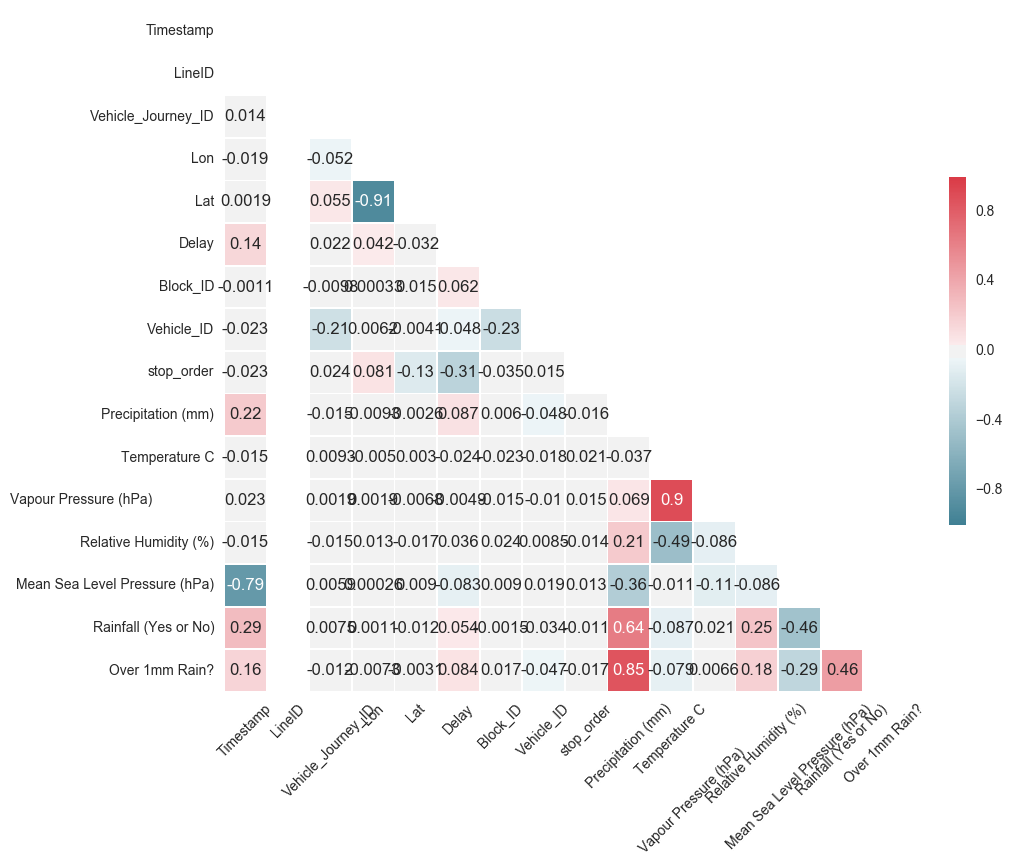

In [55]:
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

## 6.2 IsWeeekend vs. Delay

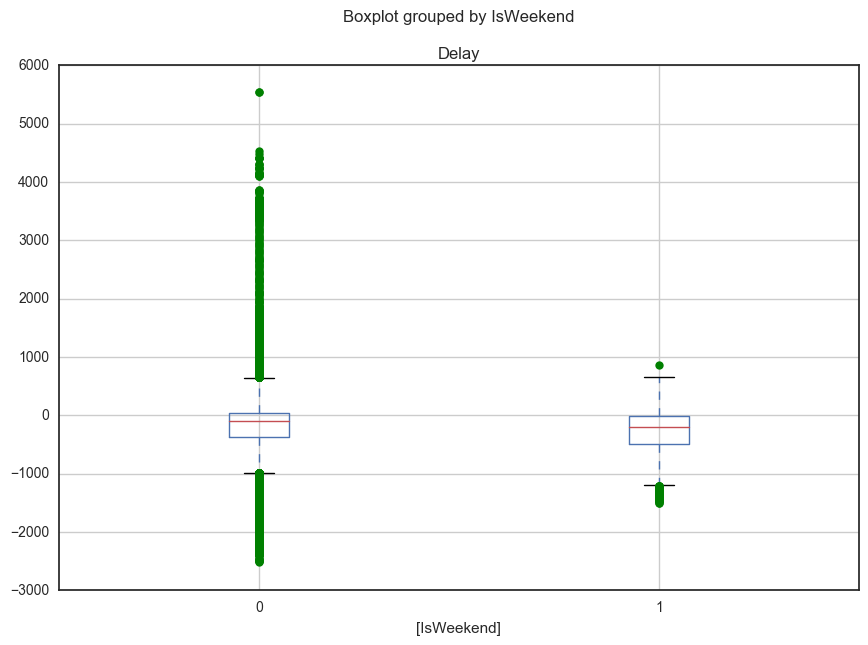

In [56]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Delay'], by=['IsWeekend'], flierprops=flierprops, figsize=(10,7))

## 6.3 IsEvening vs. Delay

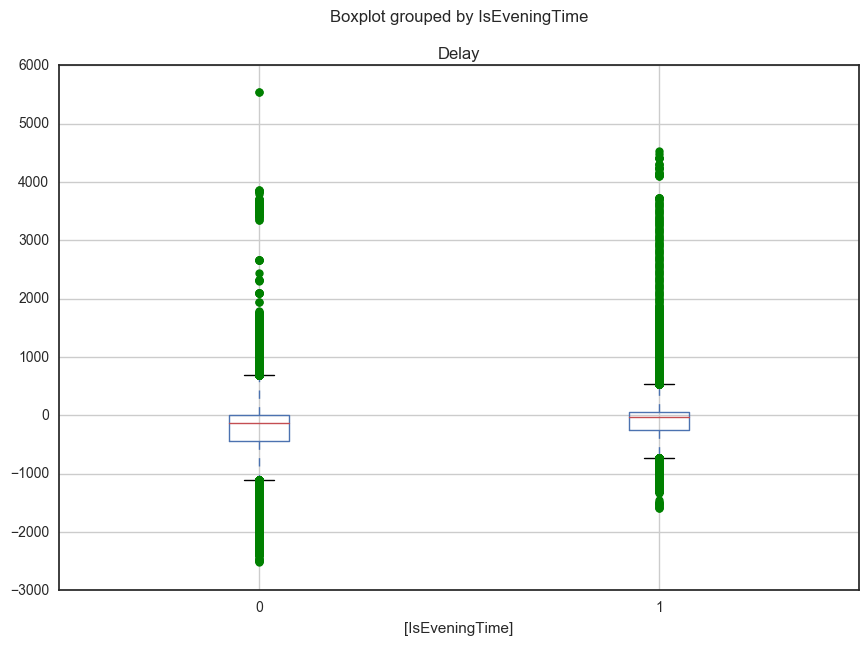

In [57]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Delay'], by=['IsEveningTime'], flierprops=flierprops, figsize=(10,7))

## 6.4 IsSchoolHoliday vs. Delay

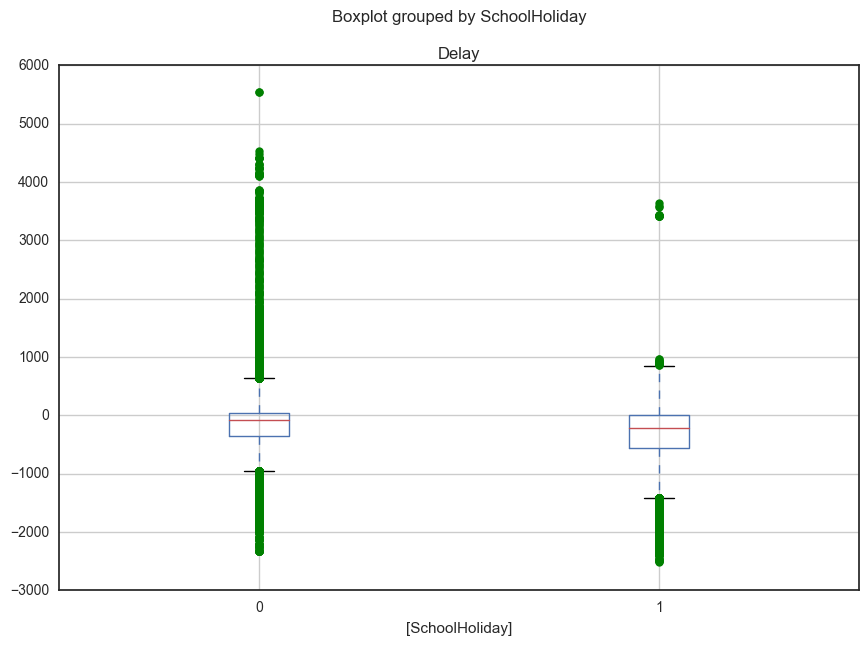

In [58]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Delay'], by=['SchoolHoliday'], flierprops=flierprops, figsize=(10,7))

## 6.5 IsPeakTime vs. Delay

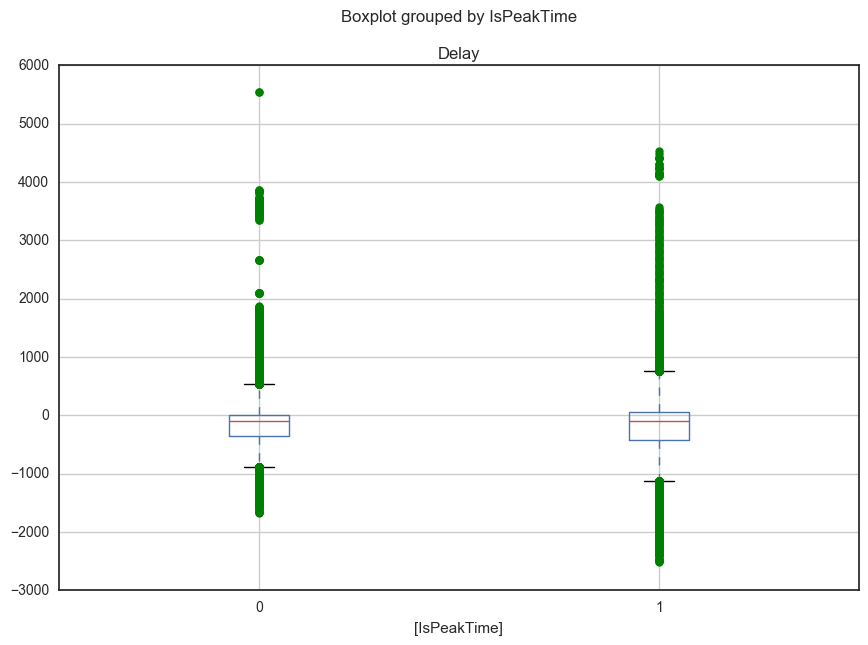

In [59]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Delay'], by=['IsPeakTime'], flierprops=flierprops, figsize=(10,7))

## 6.5 HourOfDay vs. Delay

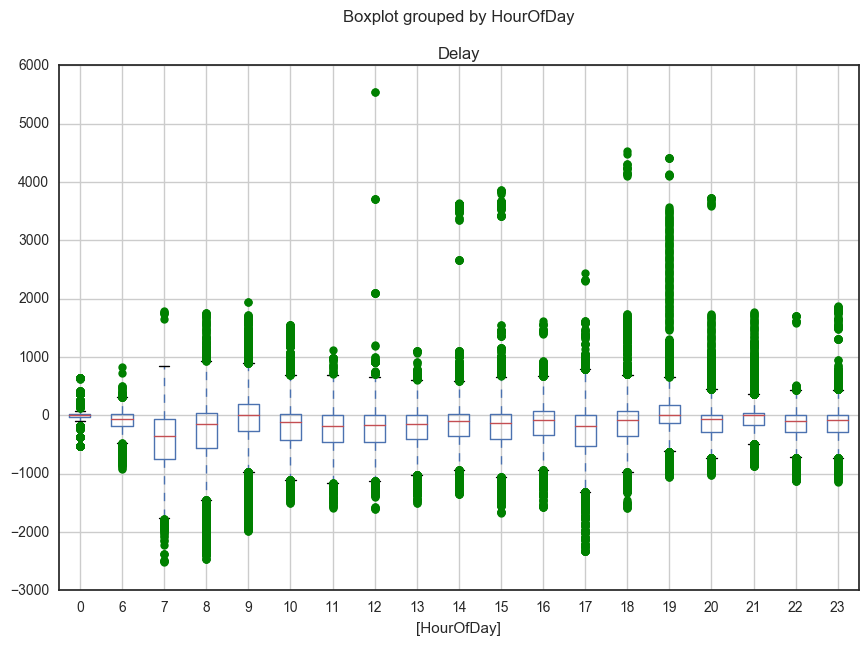

In [60]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Delay'], by=['HourOfDay'], flierprops=flierprops, figsize=(10,7))

## 6.6 Rain vs. Delay

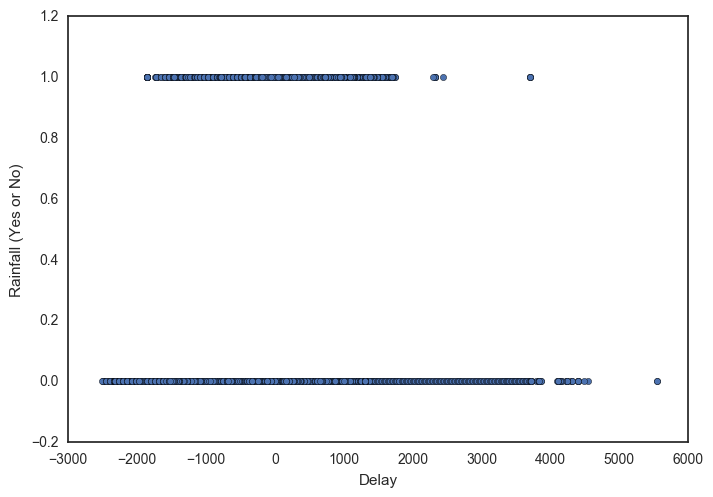

In [61]:
df.plot(kind='scatter', x='Delay', y='Rainfall (Yes or No)')

---

# 7.0 Journey Pattern ID Investigation

First run a given run on a route and investigate journey pattern ID vs other features.

## 7.1 Journey Pattern ID 00040001 - southbound bus - appears to be peak schedule

In [62]:
df_subset = df.loc[(df.Vehicle_ID == 43042) & (df.Vehicle_Journey_ID == 4915) & (df.Start_date == '2013-01-31') & (df.At_Stop == 1)]
df_subset.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
263002,1359618013000000,4.0,00040001,2013-01-31,4915,HN,-6.263807,53.392265,-88,4010,...,0,0,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
263099,1359618412000000,4.0,00040001,2013-01-31,4915,HN,-6.265924,53.372498,-409,4010,...,0,7,Mobhi Road,0.2,5.5,7.4,81.0,1001.4,1,0
263437,1359619751000000,4.0,00040001,2013-01-31,4915,HN,-6.258871,53.347191,-452,4010,...,0,9,O'Connell St,0.3,4.4,7.1,85.0,1003.0,1,0
263442,1359619772000000,4.0,00040001,2013-01-31,4915,HN,-6.258871,53.347191,-452,4010,...,0,9,O'Connell St,0.3,4.4,7.1,85.0,1003.0,1,0
263445,1359619791000000,4.0,00040001,2013-01-31,4915,HN,-6.258871,53.347191,-418,4010,...,0,9,O'Connell St,0.3,4.4,7.1,85.0,1003.0,1,0


In [63]:
for column in df_subset.columns:
    print(column + "," + str(len(df_subset[column].unique())))

Timestamp,21
LineID,1
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,17
Lat,16
Delay,16
Block_ID,1
Vehicle_ID,1
Stop_ID,15
At_Stop,1
Time,21
IsWeekend,1
HourOfDay,2
IsEveningTime,1
IsPeakTime,1
SchoolHoliday,1
stop_order,14
fullname,12
Precipitation (mm),2
Temperature C,2
Vapour Pressure (hPa)                ,2
Relative Humidity (%),2
Mean Sea Level Pressure (hPa),2
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: timestamps are out of order, this subset starts later than it finishes. The delay of being 49 seconds ahead of schedule is not in line with the 1 hour schedule from Harristown to Monkstown. So the delay is against a schedule of 1 hour 30 minutes. This is a peak time - Thursday 31/1/2013. Block ID: 4010 - stays constant Journey pattern ID: 00040001 This is a Southbound bus.

In [64]:
df_subset1 = df.loc[(df.Vehicle_ID == 33219) & (df.Vehicle_Journey_ID == 963581) & (df.Start_date == '2013-01-31') ]
df_subset1.to_csv("csv_data/southbound.csv", encoding='utf-8', index=False)
df_subset1.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
264801,1359626572000000,4.0,00040001,2013-01-31,963581,HN,-6.265333,53.412716,0,4069,...,0,0,Harristown,0.0,6.1,7.5,79.0,1004.9,0,0
264805,1359626591000000,4.0,00040001,2013-01-31,963581,HN,-6.265617,53.410217,0,4069,...,0,0,Harristown,0.0,6.1,7.5,79.0,1004.9,0,0
264808,1359626602000000,4.0,00040001,2013-01-31,963581,HN,-6.265617,53.410217,0,4069,...,0,0,Harristown,0.0,6.1,7.5,79.0,1004.9,0,0
264930,1359627050000000,4.0,00040001,2013-01-31,963581,HN,-6.263807,53.392265,-232,4069,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0
264942,1359627075000000,4.0,00040001,2013-01-31,963581,HN,-6.263801,53.392120,-232,4069,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0


In [65]:
for column in df_subset1.columns:
    print(column + "," + str(len(df_subset1[column].unique())))

Timestamp,68
LineID,1
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,60
Lat,60
Delay,42
Block_ID,1
Vehicle_ID,1
Stop_ID,20
At_Stop,2
Time,68
IsWeekend,1
HourOfDay,2
IsEveningTime,1
IsPeakTime,2
SchoolHoliday,1
stop_order,18
fullname,15
Precipitation (mm),1
Temperature C,2
Vapour Pressure (hPa)                ,2
Relative Humidity (%),2
Mean Sea Level Pressure (hPa),2
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: the timestamps are out of order again, so the bus in fact finishes at 11.08 on the Monkstown Link Road, not at 10:55 on Merrion Road. The journey delay is 25 mins ahead of schedule for a trip that began at 10.02 and finished at 11.08 which indicates that the 1 hour published schedule is not right as we should be 6 minutes behind schedule - clearly the real expected time was an hour and a half here - that is the same as the example above but this is much later in the morning - should adhere to the offpeak schedule? Again this is a southbound bus, so comparable to the journey above except for peak/offpeak. Again block ID is constant but for the same jouney in same direction it is 4069 - so different. Therefore block ID cannot represent the section of the journey pattern as per the instructions given on Moodle. But journey pattern ID is still 00040001 - so that is a bus from Harristown to Monkstown. Congestion is zero even though this is a peak time bus run so not clear what drives the congestion column.

## 7.2 Journey Pattern ID 00041002 - northbound bus - offpeak schedule

In [66]:
df_subset2 = df.loc[(df.Vehicle_ID == 43044) & (df.Vehicle_Journey_ID == 4599) & (df.Start_date == '2013-01-03')]
df_subset2.head(2)

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
26173,1357255765000000,4.0,00041002,2013-01-03,4599,HN,-6.151200,53.289516,0,4012,...,1,0,Monkstown Ave,0.0,5.8,7.6,82.0,1018.7,0,0
26177,1357255787000000,4.0,00041002,2013-01-03,4599,HN,-6.152783,53.288834,0,4012,...,1,0,Monkstown Ave,0.0,5.8,7.6,82.0,1018.7,0,0


In [67]:
for column in df_subset2.columns:
    print(column + "," + str(len(df_subset2[column].unique())))

Timestamp,53
LineID,1
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,42
Lat,41
Delay,11
Block_ID,1
Vehicle_ID,1
Stop_ID,4
At_Stop,2
Time,53
IsWeekend,1
HourOfDay,2
IsEveningTime,2
IsPeakTime,1
SchoolHoliday,1
stop_order,3
fullname,4
Precipitation (mm),1
Temperature C,1
Vapour Pressure (hPa)                ,1
Relative Humidity (%),1
Mean Sea Level Pressure (hPa),1
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: again the timestamps are out of order. This is a Northbound bus. We lose it due to date filter near the end of it's trip. However it has travelled from Monkstown to O'Connell Street in 30 mins so it seems to be going on the offpeak scedule - 1 hour. The Northbound journey pattern ID is 00041002. The block ID is constant but unrelated to journey pattern at: 4012 HN - Harristown is the operator even though this but is travelling in the opposite direction - so operator is not reflective of starting bus depot - just the operator depot for this route it seems. Note this is the last run of a day (the 11.30pm bus).

## 7.3 Journey Pattern ID 00041001 - northbound bus - offpeak schedule

In [68]:
df_subset3 = df.loc[(df.Vehicle_ID == 43039) & (df.Vehicle_Journey_ID == 4954) & (df.Start_date == '2013-01-31')]
df_subset3.head(2)

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
265491,1359629257000000,4.0,00041001,2013-01-31,4954,HN,-6.157933,53.287117,47,4007,...,0,0,Monkstown Ave,0.0,6.1,7.5,79.0,1004.9,0,0
265517,1359629401000000,4.0,00041001,2013-01-31,4954,HN,-6.166802,53.290535,-17,4007,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0


This bus is going Northbound, but cuts off around 11AM. Possibly one of the filters changes at 11AM.

In [69]:
df_subset3 = df.loc[ (df.Vehicle_Journey_ID == 4954) & (df.Start_date == '2013-01-31')]
df_subset3.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
265491,1359629257000000,4.0,00041001,2013-01-31,4954,HN,-6.157933,53.287117,47,4007,...,0,0,Monkstown Ave,0.0,6.1,7.5,79.0,1004.9,0,0
265517,1359629401000000,4.0,00041001,2013-01-31,4954,HN,-6.166802,53.290535,-17,4007,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0
265521,1359629413000000,4.0,00041001,2013-01-31,4954,HN,-6.166490,53.291435,-17,4007,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0
265535,1359629499000000,4.0,00041001,2013-01-31,4954,HN,-6.171226,53.297417,-75,4007,...,0,0,Stradbrook Rd,0.0,6.1,7.5,79.0,1004.9,0,0
265539,1359629511000000,4.0,00041001,2013-01-31,4954,HN,-6.175163,53.299015,-108,4007,...,0,0,Stradbrook Rd,0.0,6.1,7.5,79.0,1004.9,0,0


In [70]:
for column in df_subset3.columns:
    print(column + "," + str(len(df_subset3[column].unique())))

Timestamp,13
LineID,1
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,10
Lat,10
Delay,9
Block_ID,1
Vehicle_ID,1
Stop_ID,4
At_Stop,2
Time,13
IsWeekend,1
HourOfDay,1
IsEveningTime,1
IsPeakTime,1
SchoolHoliday,1
stop_order,3
fullname,4
Precipitation (mm),1
Temperature C,1
Vapour Pressure (hPa)                ,1
Relative Humidity (%),1
Mean Sea Level Pressure (hPa),1
Rainfall (Yes or No),1
Over 1mm Rain?,1


No, having tried without the filters this bus stops on Rock Road only 12 minutes into its journey. GPS tracking issues? This bus is different on Journey Pattern ID to the previous northbound buses, its Journey Pattern ID is 00041001. Also as before the block ID is constant but not in line with other journeys in same area/direction 4007.

## 7.4 Journey Pattern ID 00040002 - southbound bus - offpeak schedule¶

In [71]:
df_subset5 = df.loc[(df.Vehicle_ID == 43047) & (df.Vehicle_Journey_ID == 4570) & (df.Start_date == '2013-01-25')]
df_subset5

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
227382,1359156554000000,4.0,00040002,2013-01-25,4570,HN,-6.278478,53.417950,-51,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227386,1359156575000000,4.0,00040002,2013-01-25,4570,HN,-6.278516,53.417789,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227389,1359156593000000,4.0,00040002,2013-01-25,4570,HN,-6.276501,53.418053,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227392,1359156614000000,4.0,00040002,2013-01-25,4570,HN,-6.276501,53.418053,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227394,1359156634000000,4.0,00040002,2013-01-25,4570,HN,-6.276501,53.418053,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227396,1359156653000000,4.0,00040002,2013-01-25,4570,HN,-6.278533,53.417900,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227398,1359156673000000,4.0,00040002,2013-01-25,4570,HN,-6.265967,53.417099,-29,4003,...,0,0,Harristown,0.0,5.9,7.0,74.0,1000.1,0,0
227429,1359157054000000,4.0,00040002,2013-01-25,4570,HN,-6.263807,53.392265,-30,4003,...,0,0,Ballymun Road,0.0,5.9,7.0,74.0,1000.1,0,0
227431,1359157073000000,4.0,00040002,2013-01-25,4570,HN,-6.263795,53.391975,-1,4003,...,0,0,Ballymun Road,0.0,5.9,7.0,74.0,1000.1,0,0
227435,1359157134000000,4.0,00040002,2013-01-25,4570,HN,-6.265143,53.387920,-21,4003,...,0,1,Ballymun Road,0.0,5.9,7.0,74.0,1000.1,0,0


Friday 25 Jan 2013 was a Friday but this is an offpeak bus. It drops off at 11.51pm which is too early to be because of the date in the filter. It is a Southbound bus, last of the day.

This bus has same vehicle journey ID on a different date - but it is the last bus Southbound for the day. Again it drops off when it reaches Parnell Square, not making the full journey.

## 7.5 Have established that the 5th number in Journey Pattern ID indicates direction - 0 southbound, 1 northbound

Splice direction from JourneyPatternID and create new binary column

In [72]:
df["Direction_Northbound"] =  np.where((df["Journey_Pattern_ID"].str[5] == '1'),1, 0)

---

# 8.0 Block ID Analysis

In [73]:
block_df = df[df['Block_ID'] == 4001]
block_df.head(2)

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound
78,1357029025000000,4.0,00040001,2013-01-01,15475,HN,-6.27822,53.418144,17,4001,...,0,Harristown,0.0,2.0,6.3,89.0,1005.9,0,0,0
79,1357029045000000,4.0,00040001,2013-01-01,15475,HN,-6.27822,53.418144,17,4001,...,0,Harristown,0.0,2.0,6.3,89.0,1005.9,0,0,0


In [74]:
for column in block_df.columns:
    print(column + "," + str(len(block_df[column].unique())))

Timestamp,29977
LineID,1
Journey_Pattern_ID,2
Start_date,31
Vehicle_Journey_ID,75
Operator,1
Lon,8387
Lat,7816
Delay,1888
Block_ID,1
Vehicle_ID,39
Stop_ID,35
At_Stop,2
Time,29977
IsWeekend,2
HourOfDay,19
IsEveningTime,2
IsPeakTime,2
SchoolHoliday,2
stop_order,24
fullname,20
Precipitation (mm),23
Temperature C,120
Vapour Pressure (hPa)                ,65
Relative Humidity (%),38
Mean Sea Level Pressure (hPa),218
Rainfall (Yes or No),2
Over 1mm Rain?,2
Direction_Northbound,1


Notes: This highlights nothing about the use of block ID. We may not need it.

---

# 8.0 Model Analysis

## 8.1 Drop Some Columns (Not for good)

In [75]:
df = df.drop('Lat', axis=1)
df = df.drop('Lon', axis=1)
df = df.drop('Block_ID', axis=1)

## 8.2 Linear Model - need a time vs distance to generate km/hour

The delay is in seconds. We need to prepare a model that compares to delay for testing.

We need distance in stops or in real distances based on lon/lat positions We need, if using stops, to assume an equal distance between stops % Distance will be stop_order_number / total number of stops Time will be % distance * overall schedule time (which is 60 minutes per the offpeak #4 bus schedule) That should give a base schedule to check against. Real delay is per the dataframe. To model a delay we need to add features to time function above To model a correct time function we should take stop_order(min) from stop_order(current) Timestamp

#Time delta can't work for models - hold this cell as markdown until we confirm we can delete it
df['time_diff'] = df.groupby(['stop_order','Journey_Pattern_ID', 'Start_date', 'HourOfDay'])['Time'].diff()

In [76]:
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Delay', 'Vehicle_ID', 'Stop_ID',
       'At_Stop', 'Time', 'IsWeekend', 'HourOfDay', 'IsEveningTime',
       'IsPeakTime', 'SchoolHoliday', 'stop_order', 'fullname',
       'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?', 'Direction_Northbound'],
      dtype='object')

df.time_diff.interpolate()
df.head()

In [77]:
df['%_distance_travelled'] = df.stop_order.div(df.stop_order.max(), axis='index')

In [78]:
df=df.drop_duplicates(subset='Time', keep='first')

In [79]:
df.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Delay,Vehicle_ID,Stop_ID,At_Stop,...,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound,%_distance_travelled
1,1356998427000000,4.0,00041002,2012-12-31,4599,HN,0,43035,281,1,...,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0,0.433333
3,1356998485000000,4.0,00041002,2012-12-31,4599,HN,0,43035,281,1,...,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0,0.433333
5,1356998546000000,4.0,00041002,2012-12-31,4599,HN,0,43035,281,1,...,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0,0.433333
8,1356998607000000,4.0,00041002,2012-12-31,4599,HN,0,43035,281,1,...,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0,0.433333
9,1356998665000000,4.0,00041002,2012-12-31,4292,HN,0,43035,281,0,...,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0,0.433333


## 8.3 Random Forest Regression - Predicts the delay

In [80]:
y, X = dmatrices('Delay ~  IsWeekend+IsEveningTime+IsPeakTime+SchoolHoliday', df, return_type="dataframe") 
y = np.ravel(y)
X.head(5)

,Intercept,IsWeekend[T.1],IsEveningTime[T.1],IsPeakTime[T.1],SchoolHoliday[T.1]
1,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,1.0
9,1.0,0.0,0.0,0.0,1.0


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123)                                 

In [82]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [83]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=10))

In [84]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [85]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

In [86]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [87]:
pred = clf.predict(X_test)

In [88]:
r2_score(y_test, pred)

0.055499208718967519

Very bad score

In [89]:
mean_squared_error(y_test, pred)

161432.18423347251

Very bad score

This saves the model for later

In [97]:
joblib.dump(clf, '../flask_app/static/rf_regressor.pkl')

['../flask_app/static/rf_regressor.pkl']

This reloads the model and it can be used to predict 

In [91]:
clf2 = joblib.load('rf_regressor.pkl')

In [92]:
X_test.head()

,Intercept,IsWeekend[T.1],IsEveningTime[T.1],IsPeakTime[T.1],SchoolHoliday[T.1]
52552,1.0,0.0,0.0,0.0,0.0
61982,1.0,0.0,0.0,0.0,0.0
159418,1.0,0.0,0.0,0.0,0.0
190046,1.0,0.0,0.0,0.0,0.0
69782,1.0,0.0,0.0,1.0,0.0


In [95]:
type(clf2)

sklearn.model_selection._search.GridSearchCV

In [94]:
type(X_test)

pandas.core.frame.DataFrame

In [93]:
clf2.predict(X_test)

array([ -1.52932406e+02,  -1.52932406e+02,  -1.52932406e+02, ...,
        -2.41614718e-02,  -4.78890950e+02,  -1.52932406e+02])